In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time

%matplotlib inline

# style: darkgrid, whitegrid, dark, white, ticks
# context: talk, paper, notebook, poster
sns.reset_defaults()
sns.set_theme(rc={'figure.dpi': 72, 'savefig.dpi': 300,
              'figure.autolayout': True})
sns.set_style('ticks')
sns.set_context('paper')


In [2]:
def ReadDG(file_path: str, sep: str = None) -> dict:
    """Read Directed Graph

    Returns:
        dict: Adjacency list.
    """
    V = {}
    with open(file_path) as f:
        for l in f:
            try:
                u, v = map(int, l.split(sep))
            except:
                continue
            d = {'in': set(), 'out': set()}
            V.setdefault(u, d)['out'].add(v)
            V.setdefault(v, d)['in'].add(u)
    return V


def IC(V: dict, S: set, p: float, o: int) -> tuple:
    """Independent Cascade Model

    Args:
        V (dict): Adjacency list.
        S (set): Initial active set.
        p (float): Edge activation probability.
        o (int): Number of outbreaks.

    Returns:
        tuple: Expected reward, cost, reward/cost
    """
    reward = 0
    cost = 0
    for oi in range(o):
        Si = S.copy()
        Si_new = S.copy()
        while Si_new:
            new_neighbors = set()
            for u in Si_new:
                for v in V[u]['out']:
                    rp = random.random()
                    if rp < p:
                        new_neighbors.add(v)
                        if v not in Si:
                            cost += rp
            Si_new = new_neighbors - Si
            Si |= Si_new
        reward += 0.25 * len(Si)
        cost *= 0.8
    reward /= o
    cost /= o
    rc = 0 if cost == 0 else reward / cost
    return reward, cost, rc


def Greedy(V: dict, b: float, p: float, o: int) -> tuple:
    """Outbreak Detection through Greedy Algorithm

    Args:
        V (dict): Adjacency list.
        b (float): Budget.
        p (float): Edge activation probability.
        o (int): Number of outbreaks.

    Returns:
        tuple: nodes set, computation times, reward
    """
    S = set()
    f = 0
    cost = 0
    ctimes, stime = [], time.time()
    while cost < b:
        # Find the remaining node with largest marginal gain.
        rest = set(V.keys()) - S
        best_gain, bset_cost, best_node = 0, 0, -1
        for u in rest:
            fu, cu, _ = IC(V, S | {u}, p, o)
            gu = fu - f
            if gu > best_gain and cu <= b:
                best_gain, best_cost, best_node = gu, cu, u
        if best_node == -1:
            break
        S.add(best_node)
        f += best_gain
        cost += best_cost
        ctimes.append(time.time() - stime)
    return S, ctimes, f


def CELF_util(V: dict, b: float, p: float, o: int, sort_index: int = 1) -> tuple:
    """Outbreak Detection through CELF Algorithm

    Args:
        V (dict): Adjacency list.
        b (float): Budget.
        p (float): Edge activation probability.
        o (int): Number of outbreaks.
        sort_index (int): 1 means sort by reward, 3 means sort by reward/cost

    Returns:
        tuple: nodes set, computation times
    """

    # Perform the first iteration through greedy approach.
    stime = time.time()
    gains = [(u, *IC(V, {u}, p, o)) for u in V]
    gains.sort(key=lambda x: x[sort_index], reverse=True)
    S = {gains[0][0]}
    f = gains[0][1]
    cost = gains[0][2]
    gains = gains[1:]
    ctimes = [time.time() - stime]

    while cost < b:
        top = -1
        while top != gains[0][0]:
            top = gains[0][0]
            ft, ct, rct = IC(V, S | {top}, p, o)
            if ct > b:
                gains.pop(0)
                continue
            gt = ft - f
            gains[0] = (top, gt, ct, rct)
            gains.sort(key=lambda x: x[sort_index], reverse=True)
        if len(gains) == 0:
            break
        S.add(gains[0][0])
        f += gains[0][1]
        cost += gains[0][2]
        ctimes.append(time.time() - stime)
        gains = gains[1:]

    return S, ctimes, f


def CELF(V: dict, b: float, p: float, o: int) -> tuple:
    """Outbreak Detection through CELF Algorithm

    Args:
        V (dict): Adjacency list.
        b (float): Budget.
        p (float): Edge activation probability.
        o (int): Number of outbreaks.

    Returns:
        tuple: nodes set, computation times, reward
    """
    start = time.time()
    s1, ct1, r1 = CELF_util(V, b, p, o, 1)
    s2, ct2, r2 = CELF_util(V, b, p, o, 3)
    ct = time.time() - start
    if r2 > r1:
        ct2 = list(map(lambda x: x + ct, ct2))
        return s2, ct2, r2
    ct1 = list(map(lambda x: x + ct, ct1))
    return s1, ct1, r1


In [3]:
# Astro Physics collaboration network
# https://snap.stanford.edu/data/ca-AstroPh.html
V = ReadDG('datasets/CA-AstroPh.txt')

In [27]:
B = 0.001
P = 0.001
O = 50
random.seed(2)

In [32]:
gr_set, gr_times, gr_f = Greedy(V, b=B, p=P, o=O)

print("Greedy benefit:", gr_f)
print("Greedy nodes:", gr_set)
print("Greedy computation time:", f"{gr_times[-1]:.2f}s")

Greedy benefit: 3.3333333333333335
Greedy nodes: {93504, 81761, 9667, 69643, 23596, 75223, 35290, 86651, 53213, 32191}
Greedy computation time: 692.61s


In [31]:
ce_set, ce_times, ce_f = CELF(V, b=B, p=P, o=O)

print("CELF benefit:", ce_f)
print("CELF nodes:", ce_set)
print("CELF computation time:", f"{ce_times[-1]:.2f}s")

CELF benefit: 16.6
CELF nodes: {124928, 34945, 70275, 115076, 12680, 11913, 63625, 59277, 59278, 85779, 110740, 70291, 102806, 5527, 66707, 32664, 118170, 6548, 32796, 133142, 58654, 120732, 2856, 27690, 108330, 125612, 116397, 100778, 57649, 38450, 55729, 63284, 33203, 73271, 12218, 131133, 95680, 39108, 48073, 42572, 107852, 60108, 57295, 69202, 126550, 125399, 70488, 34524, 19166, 33886, 111072, 85986, 28003, 101994, 69228, 47213, 2159, 78191, 76784, 8561, 67955, 89461, 118520, 85883, 55805}
CELF computation time: 50.91s


Similar nodes: set()


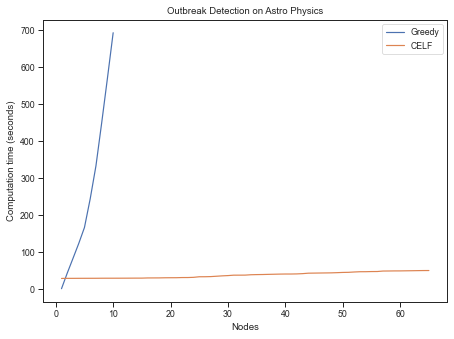

In [35]:
print("Similar nodes:", gr_set & ce_set)

gr_x = list(range(1, len(gr_times) + 1))
ce_x = list(range(1, len(ce_times) + 1))
x = ce_x if len(ce_x) < len(gr_x) else gr_x
ax = sns.lineplot(x=gr_x, y=gr_times, label="Greedy")
sns.lineplot(x=ce_x, y=ce_times, label="CELF", ax=ax)
ax.set(
    title="Outbreak Detection on Astro Physics",
    xlabel="Nodes",
    ylabel="Computation time (seconds)",
    # xticks=x,
)
plt.savefig('q5.png')
plt.show()
